In [164]:
%pip install xarray-spatial -q
%pip install datashader -q
%pip install xarray-spatial -q

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


In [165]:
from pathlib import Path

import numpy as np
import pandas as pd
import xarray as xr
import geopandas as gpd
import shapely
import rioxarray
import xrspatial

from rasterio.plot import show

import osmnx as ox # Downloading data from OSM

from shapely.geometry import box
from scipy.spatial import cKDTree as KDTree # For Inverse Distance Weight calculation

import matplotlib.pyplot as plt
from datashader.transfer_functions import shade, stack


Victoria 10m DEM data source - https://discover.data.vic.gov.au/dataset/vicmap-elevation-dem-10m/resource/2f833255-922a-4ee0-a21a-21e2a40ce867

Using 10m LiDAR DEM for Lak Eildon area, Victoria, Australia

In [166]:
crs = "EPSG:4326"
dem = rioxarray.open_rasterio('data/input/vmelev_dem10m.tif')
dem_reproj = dem.rio.reproject(crs)

geojson = gpd.read_file('data/input/eildon_shape.geojson')

print(f"CRS of input DEM: {dem.rio.crs}")
print(f"CRS of input clipping polygon: {geojson.crs}")
print(f"CRS of reprojected DEM: {dem_reproj.rio.crs}")


CRS of input DEM: EPSG:4283
CRS of input clipping polygon: EPSG:4326
CRS of reprojected DEM: EPSG:4326


In [167]:
cropped = dem_reproj.rio.clip(geometries=geojson.geometry, crs=crs)

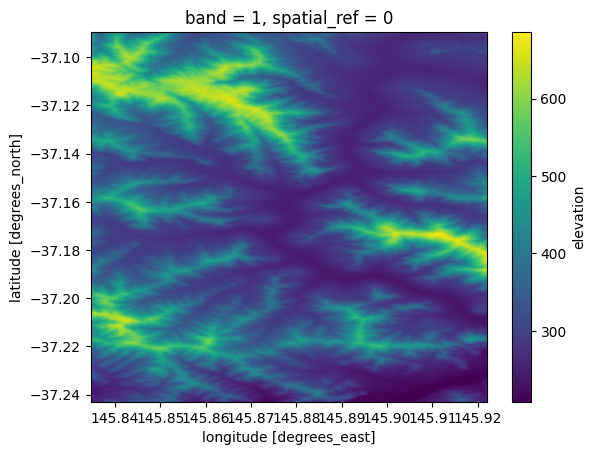

In [168]:
cropped.squeeze().plot.imshow()

<Axes: >

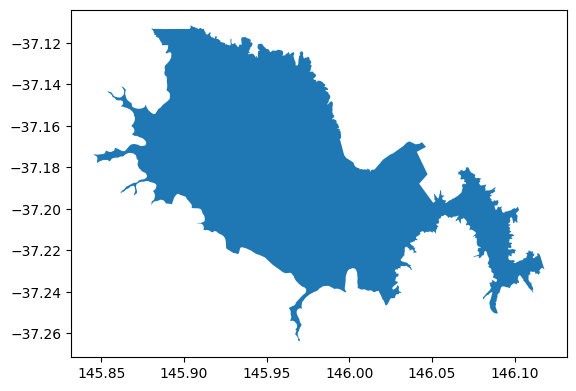

In [169]:
#OSM id for Lake Eildon, Vic

# would prefer to do this by id not name in future
lake = ox.geocode_to_gdf('Lake Eildon', which_result=1)
lake = lake.to_crs(dem.rio.crs)

lake.plot()

In [170]:
bounds = cropped.rio.bounds()
xmin, ymin, xmax, ymax = bounds

lake = lake.clip(bounds)
lake_geom = lake.geometry.iloc[0]

In [171]:
cropped = cropped.sel(y=slice(ymax, ymin), x=slice(xmin, xmax))

<Axes: title={'center': 'band = 1, spatial_ref = 0'}, xlabel='longitude [degrees_east]', ylabel='latitude [degrees_north]'>

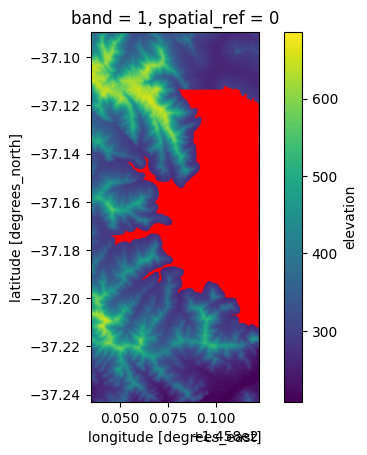

In [172]:
fig, ax = plt.subplots()
cropped.squeeze().plot.imshow(ax=ax)
lake.plot(ax=ax, color='red')

calculte the REM

To calculate the REM, we need to

- Sample the elevation along the river
- Interpolate the sampled elevation values to create a 2D elevation raster
- Subtract the interpolated elevation raster from the DEM

In [173]:
# get the coordinates as a data array

def split_coords(geom):
    x = []
    y = []
    for i in shapely.get_coordinates(geom):
        x.append(i[0])
        y.append(i[1])
    return x, y

In [174]:
xs, ys = split_coords(lake_geom)
xs, ys = xr.DataArray(xs, dims='z'), xr.DataArray(ys, dims='z')

In [175]:
# use xarray's interp to extract lake elevation

sampled = cropped.interp(x=xs, y=ys, method='nearest').dropna(dim='z')

In [176]:
#prepare data for interpolation

#sample lake coordinates
c_sampled = np.vstack([sampled.coords[c].values for c in ('x', 'y')]).T

# all x and y coords from original DEM
c_x, c_y = [cropped.coords[c].values for c in ('x', 'y')]
c_interpolate = np.dstack(np.meshgrid(c_x, c_y)).reshape(-1, 2)

# sampled values
values = sampled.values.ravel()

c_interpolate

array([[145.83467703, -37.08954381],
       [145.83477838, -37.08954381],
       [145.83487973, -37.08954381],
       ...,
       [145.92193748, -37.24288302],
       [145.92203883, -37.24288302],
       [145.92214018, -37.24288302]])

In [182]:
tree

### Inverse Distance Weighted (IDW):

IDW is a type of interpolation: a group of methods which estimate missing values in a dataset.

IDW calculates the values of unknown locations by assigning weights based on the distance between the unknown point and its nrighbouring data points. It is a simple and fast method of interpolation, but can be overly sensitive to outliers and may have a smoothing effect on your data.

In [1]:
#perform the interpolation
tree = KDTree(c_sampled)

"""
IWD interpolation: inverse distance weighting. Averages 5 nearest points based on weighting. Add more info later.
"""

distances, indices = tree.query(c_interpolate, k=100)

weights = 1/distances
weights = weights / weights.sum(axis=1).reshape(-1,1)

interpolated_values = (weights * values[indices]).sum(axis=1)

interpolated_values

NameError: name 'KDTree' is not defined

In [196]:
# make data array from interpolated values
elevation_raster = xr.DataArray(
    interpolated_values.reshape((len(c_y), len(c_x))).T, dims=('x', 'y'), coords={'x': c_x, 'y': c_y}
)

<Axes: xlabel='x', ylabel='y'>

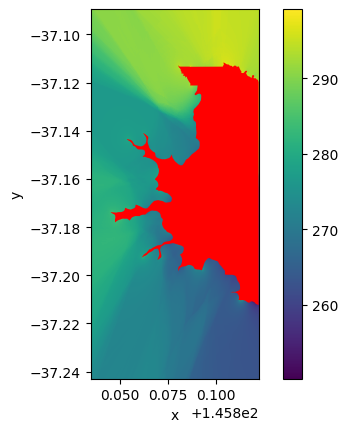

In [197]:
fig, ax = plt.subplots()
elevation_raster.transpose().plot.imshow(ax=ax)
lake.plot(ax=ax, color='red')

Calclate actual REM

In [198]:
rem = cropped - elevation_raster

rem

<xarray.DataArray (band: 1, y: 1514, x: 864)> Size: 10MB
array([[[ 1.41372452e+02,  1.40763693e+02,  1.39751130e+02, ...,
         -2.78978509e+00, -2.78864183e+00, -3.05552908e+00],
        [ 1.46647806e+02,  1.45835285e+02,  1.43903089e+02, ...,
         -4.01645612e+00, -4.01530644e+00, -4.19718226e+00],
        [ 1.51040113e+02,  1.49595937e+02,  1.46999804e+02, ...,
         -5.11595436e+00, -5.07927036e+00, -5.24297379e+00],
        ...,
        [-2.66031098e+01, -2.55053138e+01, -2.40665620e+01, ...,
         -1.06408912e+00, -1.06240469e+00,  1.68782341e-02],
        [-2.63467002e+01, -2.50756106e+01, -2.34238540e+01, ...,
         -3.22972752e-01, -3.21296728e-01,  1.01344050e+00],
        [-2.60129936e+01, -2.44234109e+01, -2.28052282e+01, ...,
          5.78582348e-01,  5.80250022e-01,  2.26117038e+00]]])
Coordinates:
  * x            (x) float64 7kB 145.8 145.8 145.8 145.8 ... 145.9 145.9 145.9
  * y            (y) float64 12kB -37.09 -37.09 -37.09 ... -37.24 -37.24 -37.24
  * band         (band) int64 8B 1
    spatial_ref  int64 8B 0

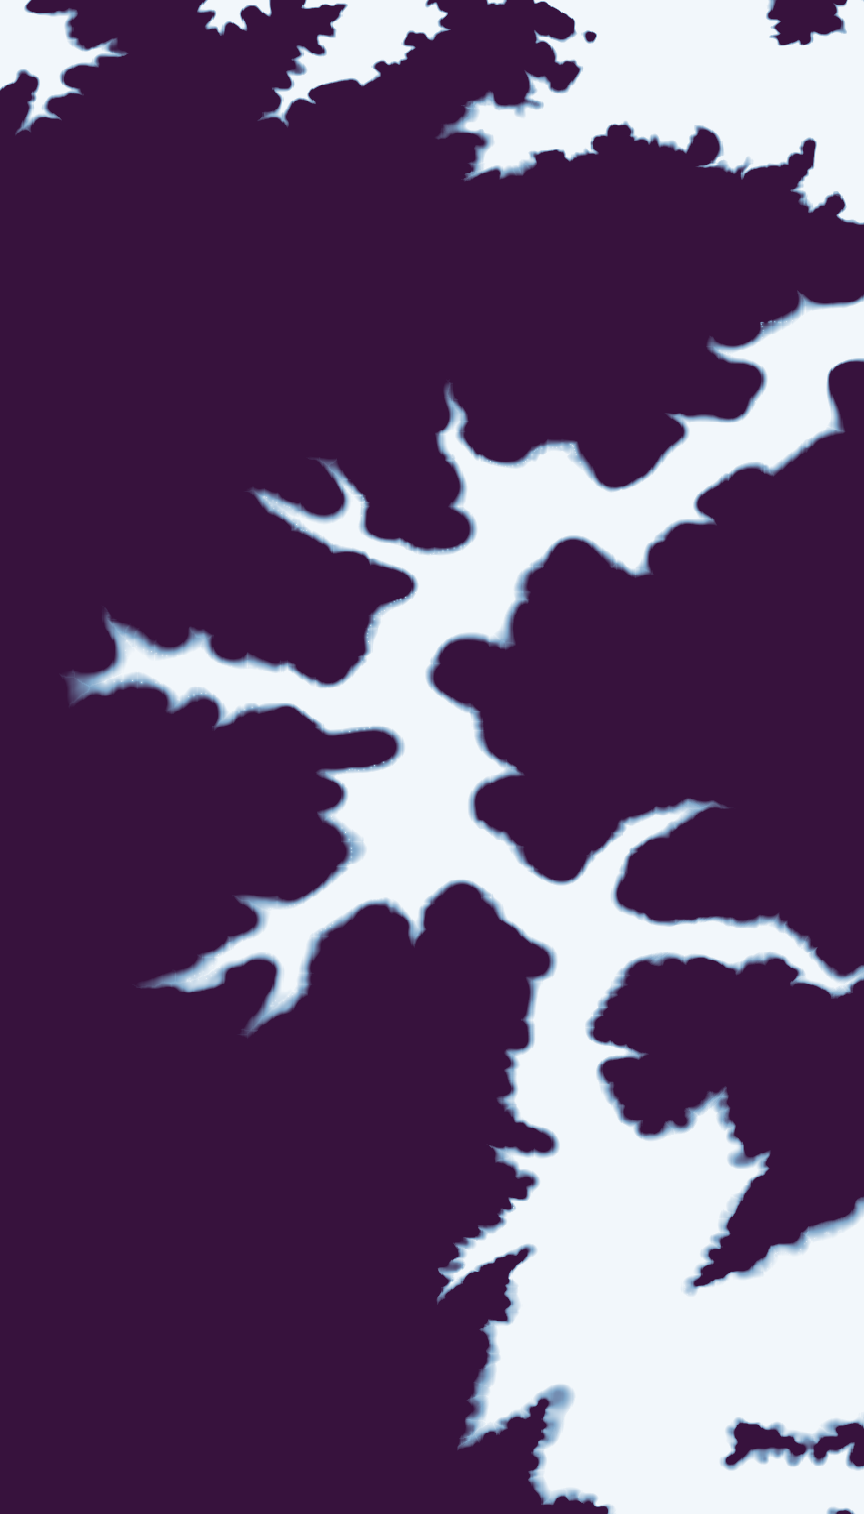

In [199]:
colors = ['#f2f7fb', '#81a8cb', '#37123d']

shade(rem.squeeze(), cmap=colors, span=[0, 10], how='linear')

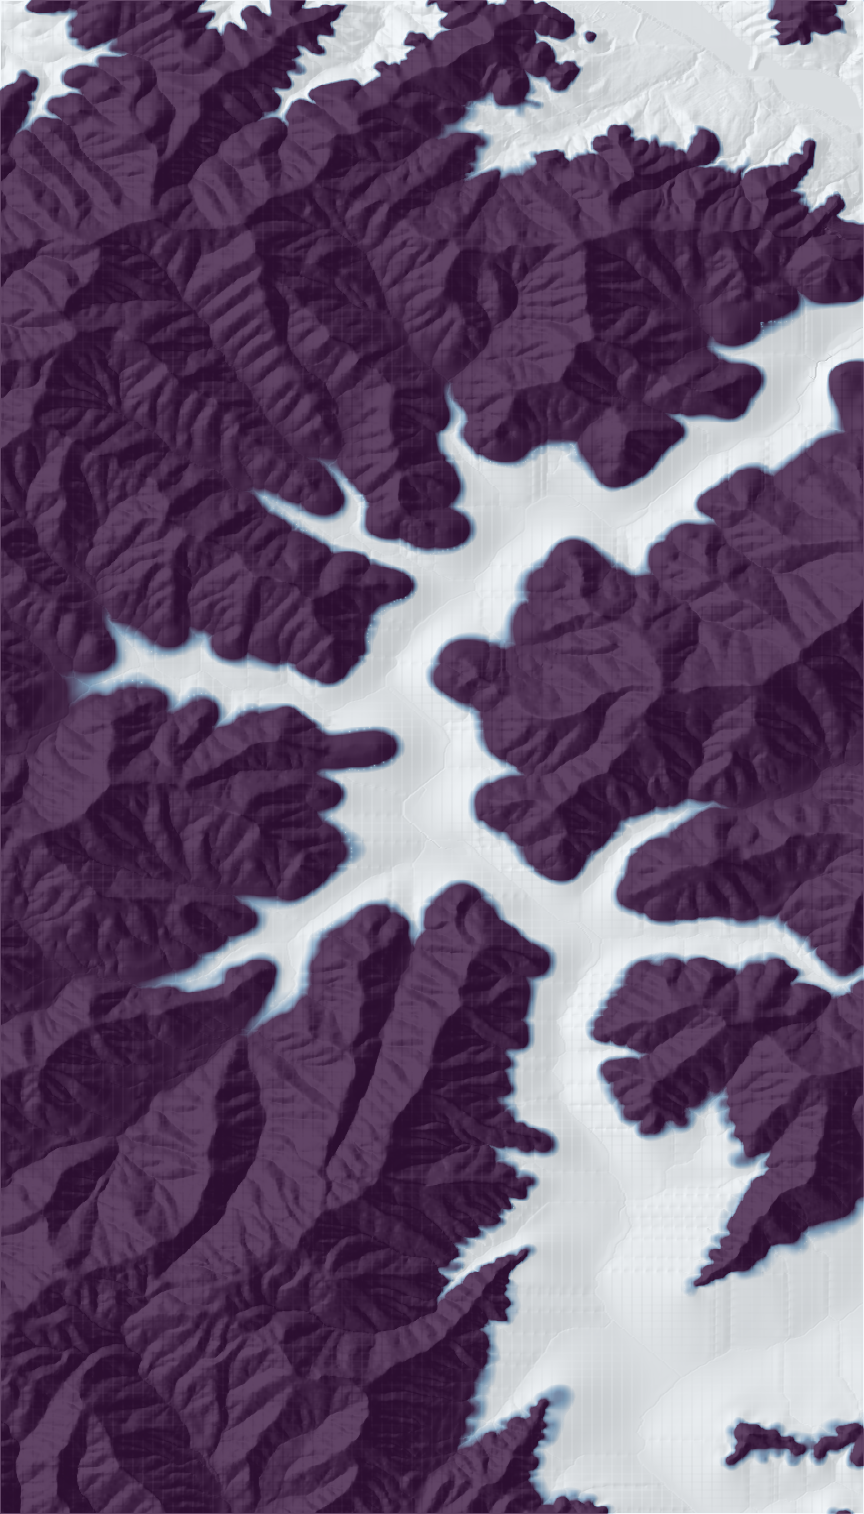

In [203]:
a = shade(xrspatial.hillshade(cropped.squeeze(), angle_altitude=1, azimuth=250), cmap=['black', 'white'], how='linear')
b = shade(rem.squeeze(), cmap=colors, span=[0, 10], how='linear', alpha=200)
stack(a, b)